# Problem Statement - Model that predicts the daily sales for store X as per the test data set provided

## Part 1- EDA

*********************************************************************************************************************

# TABLE OF CONTENTS

## 1.1 - Analysing Train and Test Dataset
   ## 1.2 - Analysing Store Data 
##### 1.2.1-Data Preperation - Merging the Train and the Store data
## 1.3 - Feature Engineering - Adding some features for the EDA
## 1.4 - Visualising and Analysing the Features
## 1.5 - EDA Takeaways and Observations

*********************************************************************************************************************

# Assimptions Used while doing the Analysis for this problem statement:
    
**Store name is X which operates in some country X**

### New Features added for the purpose of EDA only:

#### Date Features:
1. Year
2. Month
3. Week
4. Week of year
6. Sales Per Customer
7. Avg Sales
8. % Change in Sales
9. Competiton Open in Months

#### Which features I could have added value but I was unable to add them due to lack of some information

**State/Country and Weather Info** - I was not able to attach a specific country/state to the given data set. Though we have been given the information as to when the stores will be closed and I have extracted the dates as to when these stores are closed, still it is a tedious task to identify which country it is in which this store belongs. I looked up and found that it could be either Germany or even Austria as they share some of the common holidays. If I would have to know the country at least, I could have added the state and following the state I could have simply added the weather and that would have given some extra features like Temperature, Humidity, Wind Pressure, Snowfall, etc.

I did some exploration of this and details are in the attached code :Statewise Info for stores.ipynb
##### NOTE: A lot of different features have been added for Part 2 of this task for an efficient  model development
*********************************************************************************************************************
### Missing values treated for

CompetitionDistance, 

CompetitionOpenSinceMonth, CompetitionOpenSinceYear,

Promo2SinceWeek,Promo2SinceYear,PromoInterval

##### Color pallete used : Blues_r and Blues_d


*********************************************************************************************************************

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.2, color_codes=True)
from IPython.display import display
import datetime
import warnings
warnings.filterwarnings("ignore")

from termcolor import colored
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [2]:
os.getcwd()

'/Users/ishanbabbar/Documents/Python notebooks and projects/take_home_task_(3)'

# 1. Information about data

## 1.1 Train and Test Data types

**train.csv and test.csv**

• Id - an Id that represents a (Store, Date) duple within the test set


• Store - a unique Id for each store


• Sales - the turnover for any given day (prediction target)


• Customers - the number of customers on a given day


• Open - an indicator for whether the store was open: 0 = closed, 1 = open


• StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays
and weekends.

    a = public holiday, b = Easter holiday, c = Christmas, 0 = None

• SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public
schools

In [3]:
#Reading Train Data
df_train = pd.read_csv('train.csv', 
                       parse_dates=['Date'],
                       date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))
#Reading test data
df_test = pd.read_csv('test.csv', 
                        parse_dates=['Date'],
                        date_parser=(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d')))


In [4]:
display(df_train.head())
display(df_test.head())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [5]:
df_train.info()
print("****************************")
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null datetime64[ns]
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB
****************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null datetime64[ns]
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null i

In [6]:
#check for null values for train data
def find_missing(data):
    # number of missing values
    count_missing = data.isnull().sum().values
    # total records
    total = data.shape[0]
    ratio_missing = count_missing/total
    return pd.DataFrame(data={'missing_count':count_missing, 'missing_ratio':ratio_missing}, index=data.columns.values)
find_missing(df_train).head(10)

,missing_count,missing_ratio
Store,0,0.0
DayOfWeek,0,0.0
Date,0,0.0
Sales,0,0.0
Customers,0,0.0
Open,0,0.0
Promo,0,0.0
StateHoliday,0,0.0
SchoolHoliday,0,0.0


**No missing value can be seen in the train dataset. But still I would like to remove all data points where there were no sales at all be it store open or closed**

In [7]:
# Now let's deal with the situation where the store is closed or Open but there is no sale at all
# We dont' need to take into account such data points where no sale has happened at all
# So I will drop these points

df_train=df_train.drop(df_train[(df_train.Open == 0) & (df_train.Sales == 0)].index)
#Store open but not sales
df_train=df_train.drop(df_train[(df_train.Open != 0) & (df_train.Sales == 0)].index)
df_train = df_train.reset_index(drop=True)
print ("Updated Train dataset shape is {}".format(colored(df_train.shape,'red')))

Updated Train dataset shape is (844338, 9)


In [8]:
#A quick glance into all the unique values for all the important cols
display(df_train['DayOfWeek'].unique())
display(df_train['Open'].unique())
display(df_train['Promo'].unique())
display(df_train['SchoolHoliday'].unique())
display(df_train['StateHoliday'].unique())

array([5, 4, 3, 2, 1, 7, 6])

array([1])

array([1, 0])

array([1, 0])

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [9]:
#Let's check for descriptive stats now
display(df_train.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
Store,844338.0,558.421374,321.730861,1.0,280.0,558.0,837.0,1115.0
DayOfWeek,844338.0,3.520350,1.723712,1.0,2.0,3.0,5.0,7.0
Sales,844338.0,6955.959134,3103.815515,46.0,4859.0,6369.0,8360.0,41551.0
Customers,844338.0,762.777166,401.194153,8.0,519.0,676.0,893.0,7388.0
Open,844338.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
Promo,844338.0,0.446356,0.497114,0.0,0.0,0.0,1.0,1.0
SchoolHoliday,844338.0,0.193578,0.395102,0.0,0.0,0.0,0.0,1.0


##### From the above, Let's dive into Sales and Customers a little bit more. It is important for us to understand that how much higher or lower sales happened and how many hihgher or lower customers where there.

##### It will help us to identify if there are outliers or not

{'Mean': 6955.959133664481, 'Median': 6369.0}

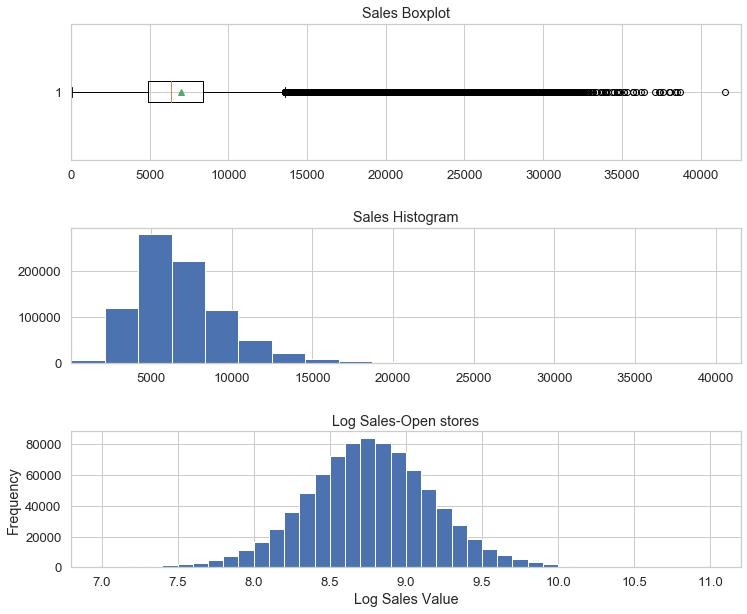

In [10]:
#Let's first see Sales Distribution
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(12,10))
plt.subplots_adjust(hspace = 0.5)
ax1.boxplot(df_train.Sales, showmeans=True,vert=False)
ax1.set_xlim(0,max(df_train["Sales"]+1000))
ax1.set_title('Sales Boxplot')

ax2.hist(df_train.Sales, cumulative=False, bins=20)
ax2.set_title("Sales Histogram")
ax2.set_xlim((min(df_train.Sales), max(df_train.Sales)))

ax3.hist(x = np.log(df_train["Sales"]), range=(7,11), bins=40)
ax3.set_title("Log Sales-Open stores")
ax3.set_xlabel('Log Sales Value')
ax3.set_ylabel('Frequency')


{"Mean":np.mean(df_train.Sales),"Median":np.median(df_train.Sales)}

In [11]:
print ("{0:.0f}% of the time this store chain had big sales day over and above regular sales(probable outliers).".format(df_train[df_train.Sales>14000].count()[0]/df_train.shape[0]*100))
print ("{0:.0f}% of the time this store chain had no sales at all.".format(df_train[df_train.Sales==0].count()[0]/df_train.shape[0]*100))

3% of the time this store chain had big sales day over and above regular sales(probable outliers).
0% of the time this store chain had no sales at all.


>As the sales is not normally distributed, we will be using Log(sales) for an efficient model development with the combination of the error metric RMSPE

In [12]:
#as an outlier seen above:
df_train[df_train.Sales>40000]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
38929,909,1,2015-06-22,41551,1721,1,0,0,0


{'Mean': 762.777166253325, 'Median': 676.0}

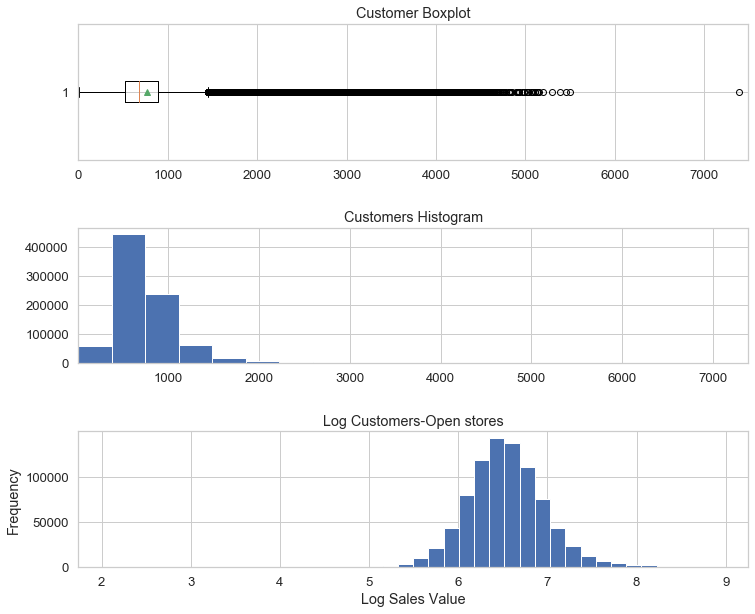

In [13]:
#Secondly, lets see the customer distribution
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(12,10))
plt.subplots_adjust(hspace = 0.5)
ax1.boxplot(df_train.Customers, showmeans=True,vert=False)
ax1.set_xlim(0,max(df_train["Customers"]+100))
ax1.set_title('Customer Boxplot')

ax2.hist(df_train.Customers, cumulative=False, bins=20)
ax2.set_title("Customers Histogram")
ax2.set_xlim((min(df_train.Customers), max(df_train.Customers)))

ax3.hist(x = np.log(df_train["Customers"]), bins=40)
ax3.set_title("Log Customers-Open stores")
ax3.set_xlabel('Log Sales Value')
ax3.set_ylabel('Frequency')

{"Mean":np.mean(df_train.Customers),"Median":np.median(df_train.Customers)}

In [14]:
print ("{0:.0f}% of the time this store chain had customers more than usual (probable outliers).".format(df_train[df_train.Customers>1500].count()[0]/df_train.shape[0]*100))
print ("{0:.0f}% of the time this store chain had no customers at all.".format(df_train[df_train.Customers==0].count()[0]/df_train.shape[0]*100))

4% of the time this store chain had customers more than usual (probable outliers).
0% of the time this store chain had no customers at all.


In [15]:
#as an outlier seen above:
df_train[df_train.Customers>7000]


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
825160,817,2,2013-01-22,27190,7388,1,1,0,0


**What we can infer from Train Dataset:**
1. The first assumption that we have used here to remove data points with 0 sales is correct. This will reduce noise in the data going forward. We don't want to bias our decision tree models to consider those exceptions, the best solution here is to get rid of closed stores and prevent the models to train on them and get false guidance.

2. There are still some open stores with no sales at all on a working day but that subset is really small with only 54 entry points. This may have happened because of external reasons, like accidents, protests, etc. Eventually removed these points

3. High correlation can be seen between sales and customers. The movement of sales is directly proportional to customer footfall and the same can be seen

4. We observe a right skewness in both distributions because of the low number of outliers but the high representation of each outlier alone which pushes the distribution to the left as seen in both histograms. This typically occurs when the mean is higher than the median.

5. Some outliers can be seen in both Sales and Customers plots but we will see later how much they account for any noise. These might have occurred due to wrong data input, maybe? or the outliers especially on the Sales plot could be because of a huge promotional sale going on, the store could be in a high street place and very popular

## 1.2 Let's now look into the Store Dataset


**store.csv**

• StoreType - differentiates between 4 different store models: a, b, c, d
    
• Assortment - describes an assortment level: a = basic, b = extra, c = extended
    
• CompetitionDistance - distance in meters to the nearest competitor store

• CompetitionOpenSince [Month/Year] - gives the approximate year and month of
the time the nearest competitor was opened

• Promo - indicates whether a store is running a promo on that day

• Promo2 - is a continuing and consecutive promotion for some stores: 0 = store is
not participating, 1 = store is participating

• Promo2Since [Year/Week] - describes the year and calendar week when the store
started participating in Promo2

• PromoInterval - describes the consecutive intervals Promo2 is started, naming
the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [16]:
#Reading Store Data
df_store = pd.read_csv('store.csv')

In [17]:
display(df_store.head())

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [18]:
print(f'Shape of train dataset is {df_store.shape}. \n')
print('*'*50 + '\n')

df_store.info()

Shape of train dataset is (1115, 10). 

**************************************************

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [19]:
#Missing value for store data
find_missing(df_store).head(15)

,missing_count,missing_ratio
Store,0,0.000000
StoreType,0,0.000000
Assortment,0,0.000000
CompetitionDistance,3,0.002691
CompetitionOpenSinceMonth,354,0.317489
CompetitionOpenSinceYear,354,0.317489
Promo2,0,0.000000
Promo2SinceWeek,544,0.487892
Promo2SinceYear,544,0.487892
PromoInterval,544,0.487892


**Missing values can be seen:**

1. CompetitionDistance, 
2. CompetitionOpenSinceMonth, CompetitionOpenSinceYear,
3. Promo2SinceWeek,Promo2SinceYear,PromoInterval

Lets Move forwrd to impute missing values

In [20]:
#Imputing Missing Values
#First We have to impute for "CompetitionDistance". To choose the right metric for imputation lets check the tendendancy of data:
{"Mean":np.nanmean(df_store.CompetitionDistance),"Median":np.nanmedian(df_store.CompetitionDistance),"Standard Dev":np.nanstd(df_store.CompetitionDistance)}


{'Mean': 5404.901079136691,
 'Median': 2325.0,
 'Standard Dev': 7659.7282732764415}

A huge difference can be seen between Mean and Median and on top of that, the STDEV is too high as well. This also indicates a higher dispersion and the same can be seen with the presence of a high standard deviation. 
So to impute "CompetitionDistance", let's go with the median

In [21]:
df_store['CompetitionDistance'].fillna(df_store['CompetitionDistance'].median(), inplace = True)

In [22]:
#Imputing CompetitionOpenSinceMonth, CompetitionOpenSinceYear
#Have to be 0 as well since they are linked to CompetitionDistance.
# Another way to imput blanks here would be to create a multilabel classification problem and then identifying the month ans year for such blank fields.

df_store.CompetitionOpenSinceMonth.fillna(0, inplace = True)
df_store.CompetitionOpenSinceYear.fillna(0,inplace=True)

In [23]:
#Imputing Blanks for Promo2SinceWeek,Promo2SinceYear,PromoInterval
#Missing values comes from fields where Promo2=0 which means there are no continuous promotional activities for those stores.
#Have to be 0 as well since they are linked to Promo2.

df_store.Promo2SinceWeek.fillna(0,inplace=True)
df_store.Promo2SinceYear.fillna(0,inplace=True)
df_store.PromoInterval.fillna(0,inplace=True)

In [24]:
#Let's check for blanks again
find_missing(df_store).head(15)

,missing_count,missing_ratio
Store,0,0.0
StoreType,0,0.0
Assortment,0,0.0
CompetitionDistance,0,0.0
CompetitionOpenSinceMonth,0,0.0
CompetitionOpenSinceYear,0,0.0
Promo2,0,0.0
Promo2SinceWeek,0,0.0
Promo2SinceYear,0,0.0
PromoInterval,0,0.0


**No Missing Values in Store dataset now**

In [25]:
display(df_store.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
Store,1115.0,558.000000,322.017080,1.0,279.5,558.0,836.5,1115.0
CompetitionDistance,1115.0,5396.614350,7654.513635,20.0,720.0,2325.0,6875.0,75860.0
CompetitionOpenSinceMonth,1115.0,4.930942,4.284924,0.0,0.0,4.0,9.0,12.0
CompetitionOpenSinceYear,1115.0,1370.939013,935.467654,0.0,0.0,2006.0,2011.0,2015.0
Promo2,1115.0,0.512108,0.500078,0.0,0.0,1.0,1.0,1.0
Promo2SinceWeek,1115.0,12.083408,15.542241,0.0,0.0,1.0,22.0,50.0
Promo2SinceYear,1115.0,1030.239462,1006.038782,0.0,0.0,2009.0,2012.0,2015.0


## 1.2.1 Merging Train and Store Datasets
(As there are no blank values now)

In [26]:
#Merging the dataset
df_train1 = pd.merge(df_train, df_store, on='Store')

## 1.3 Feature Engineering - Adding some features for the EDA

In [27]:
#Lets Add some new features to our merged dataset

# df_train_store_open = df_train1["Sales"] > 0
# df_train1 = df_train1.sort_values(['Date'],ascending = False)

#adding Year, MOnth and Week from the given date
df_train1['Year']  = df_train1['Date'].dt.year
df_train1['Month'] = df_train1['Date'].dt.month
df_train1['WeekOfYear'] = df_train1['Date'].dt.weekofyear

#Adding Sales Per Customer
df_train1['salespercustomer']=df_train1['Sales']/df_train1['Customers']

#Calculating Average Sales
avg_Sales = df_train1.groupby(['Year','Month'])["Sales"].mean()
#Calculating %change in sales
change_in_sales = df_train1.groupby(['Year','Month'])["Sales"].sum().pct_change()

#difference of months since the competietion was open
df_train1['CompetitionOpenInMonths'] = 12 * (df_train1.Year - df_train1.CompetitionOpenSinceYear) + \
        (df_train1.Month - df_train1.CompetitionOpenSinceMonth)
df_train1['CompetitionOpenInMonths'] = df_train1['CompetitionOpenInMonths'].apply(lambda x: x if x > 0 else 0)

In [28]:
print ("Merged dataset with additional features. The shape is {}".format(colored(df_train1.shape,'red')))
print('*'*50 + '\n')
df_train1.info()

Merged dataset with additional features. The shape is (844338, 23)
**************************************************

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 23 columns):
Store                        844338 non-null int64
DayOfWeek                    844338 non-null int64
Date                         844338 non-null datetime64[ns]
Sales                        844338 non-null int64
Customers                    844338 non-null int64
Open                         844338 non-null int64
Promo                        844338 non-null int64
StateHoliday                 844338 non-null object
SchoolHoliday                844338 non-null int64
StoreType                    844338 non-null object
Assortment                   844338 non-null object
CompetitionDistance          844338 non-null float64
CompetitionOpenSinceMonth    844338 non-null float64
CompetitionOpenSinceYear     844338 non-null float64
Promo2                       844338 no

In [29]:
# df_train1.to_csv(r'df_train1.csv')

## 1.4 Visualising and Analysing the Features

### Sales Analysis - Trends and Seasonlaities

To understand Sales, we need to plot the following and see what are the key patterns and insights that we can draw from Sales activites:
1. Avg and %change in sales MOM
2. Sales distribution taking a sample store from each store type to represent the population
3. Monthly Sales trends and seasonalites using Decomposition. We can also look at residual and level
4. ACF and PACF with a certain lag(here I have taken 90 days of lag to show this)

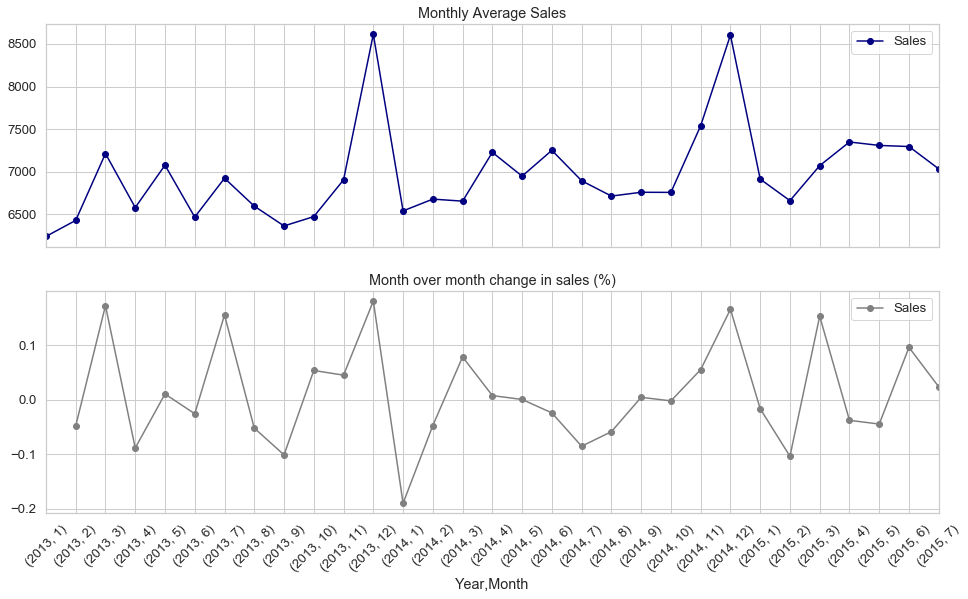

In [30]:
# Let's now see the average sales and net percent change in sales that happened over the period of time
fig, (ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(16,9))
# plot average sales MOM
ax1 = avg_Sales.plot(legend=True,ax=ax1,marker='o',color="navy", title="Monthly Average Sales")
ax1.set_xticks(range(len(avg_Sales)))
ax1.set_xticklabels(avg_Sales.index.tolist(), rotation=90)        
# plot percent change MOM
ax2 = change_in_sales.plot(legend='True',ax=ax2,marker='o',rot=45,color="grey",title="Month over month change in sales (%)")

**What we can infer from DayofWeek plots:**
1. It can be seen that there is evidence of peaks followed by troughs in monthly average sales. Almost for every steep rise in sales, there is an immediate fall.
2. A sharp rise in sales can be seen during the end of the year, around Christmas time and smaller spikes can be seen  during the summer months (June-September)
3. Steep decline can be seen in the month of January every year because of the end of the festive season

##### Now let's take a sample store from each store type that can help us in showing a trend/Seasonlaity of sales.


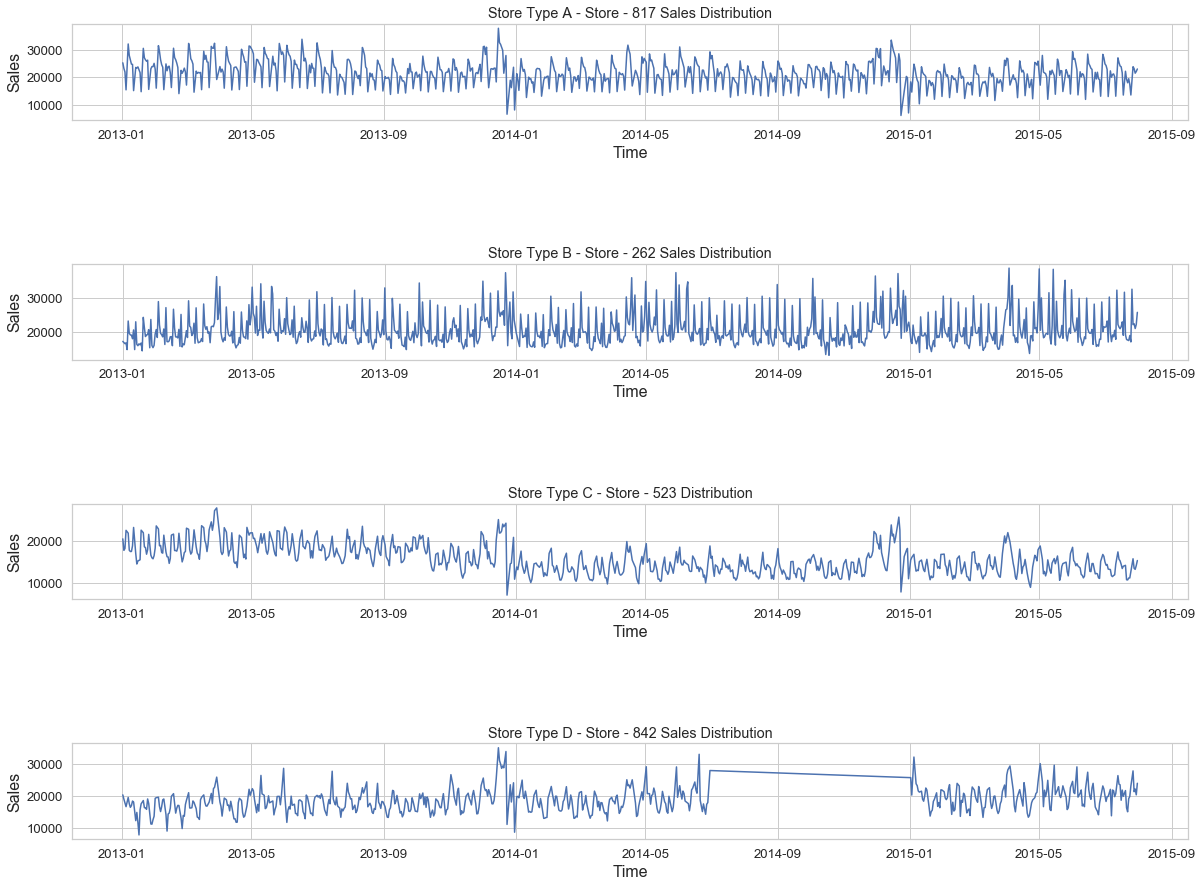

In [31]:
# After running a quick pivot in excel, I have found these four stores having highest average sales over the entire period:
#a    b      c    d
#817 262   523  842
store_typ_a = df_train1.loc[(df_train1["Store"]==817) , ['Date',"Sales"]].set_index('Date')
store_typ_b = df_train1.loc[(df_train1["Store"]==262) , ['Date',"Sales"]].set_index('Date')
store_typ_c = df_train1.loc[(df_train1["Store"]==523) , ['Date',"Sales"]].set_index('Date')
store_typ_d = df_train1.loc[(df_train1["Store"]==842) , ['Date',"Sales"]].set_index('Date')


#Plot these numbers while resampling to monthly to see some treds/seasonlaities
f, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize = (20,15))
plt.subplots_adjust(hspace = 1.5)
# store types
ax1.plot(store_typ_a['Sales'], '-')
ax1.set_xlabel('Time',fontsize=16)
ax1.set_ylabel('Sales',fontsize=16)
ax1.set_title('Store Type A - Store - 817 Sales Distribution')

ax2.plot(store_typ_b['Sales'], '-')
ax2.set_xlabel('Time',fontsize=16)
ax2.set_ylabel('Sales',fontsize=16)
ax2.set_title('Store Type B - Store - 262 Sales Distribution')

ax3.plot(store_typ_c['Sales'], '-')
ax3.set_xlabel('Time',fontsize=16)
ax3.set_ylabel('Sales',fontsize=16)
ax3.set_title('Store Type C - Store - 523 Distribution')

ax4.plot(store_typ_d['Sales'], '-')
ax4.set_xlabel('Time',fontsize=16)
ax4.set_ylabel('Sales',fontsize=16)
ax4.set_title('Store Type D - Store - 842 Sales Distribution')

plt.show()

An increasing sales pattern can be seen over Christmas! Expected. 
Store Type D could be running into refurbishments or some different manifestations where there is straight line for sales

**Let's check Sales trend using the decompose fucntion from statsmodel
This will help us derive better results in terms of seeing different trends,seasonolaities or residuals**


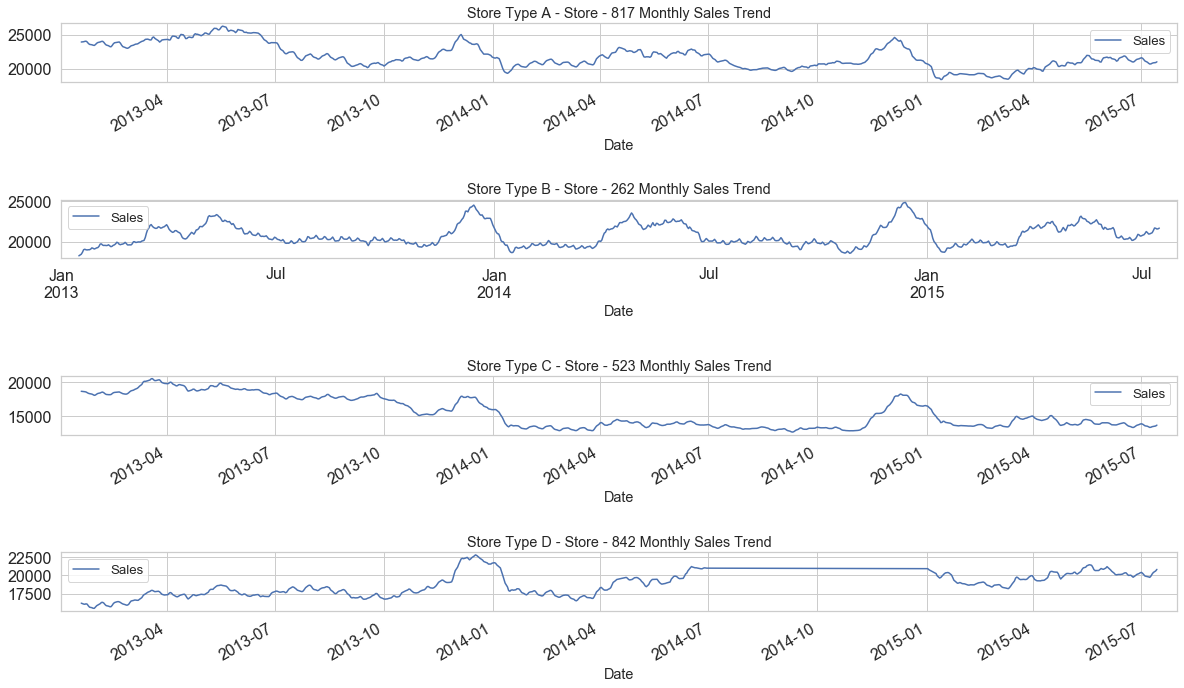

In [32]:
#Will see the analysis for the same four stores above and will look for Monthyly Trends
f, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (20, 12))
plt.subplots_adjust(hspace = 2)
# monthly trend to be shown here
decomp_a = seasonal_decompose(store_typ_a, model = 'additive', freq = 30)
decomp_a.trend.plot(ax=ax1,fontsize=16,title= "Store Type A - Store - 817 Monthly Sales Trend")

decomp_b = seasonal_decompose(store_typ_b, model = 'additive', freq = 30)
decomp_b.trend.plot(ax=ax2,fontsize=16, title ="Store Type B - Store - 262 Monthly Sales Trend")

decomp_c = seasonal_decompose(store_typ_c, model = 'additive', freq = 30)
decomp_c.trend.plot(ax=ax3,fontsize=16,title ="Store Type C - Store - 523 Monthly Sales Trend")

decomp_d = seasonal_decompose(store_typ_d, model = 'additive', freq = 30)
decomp_d.trend.plot(ax=ax4,fontsize=16, title = "Store Type D - Store - 842 Monthly Sales Trend")

plt.show()

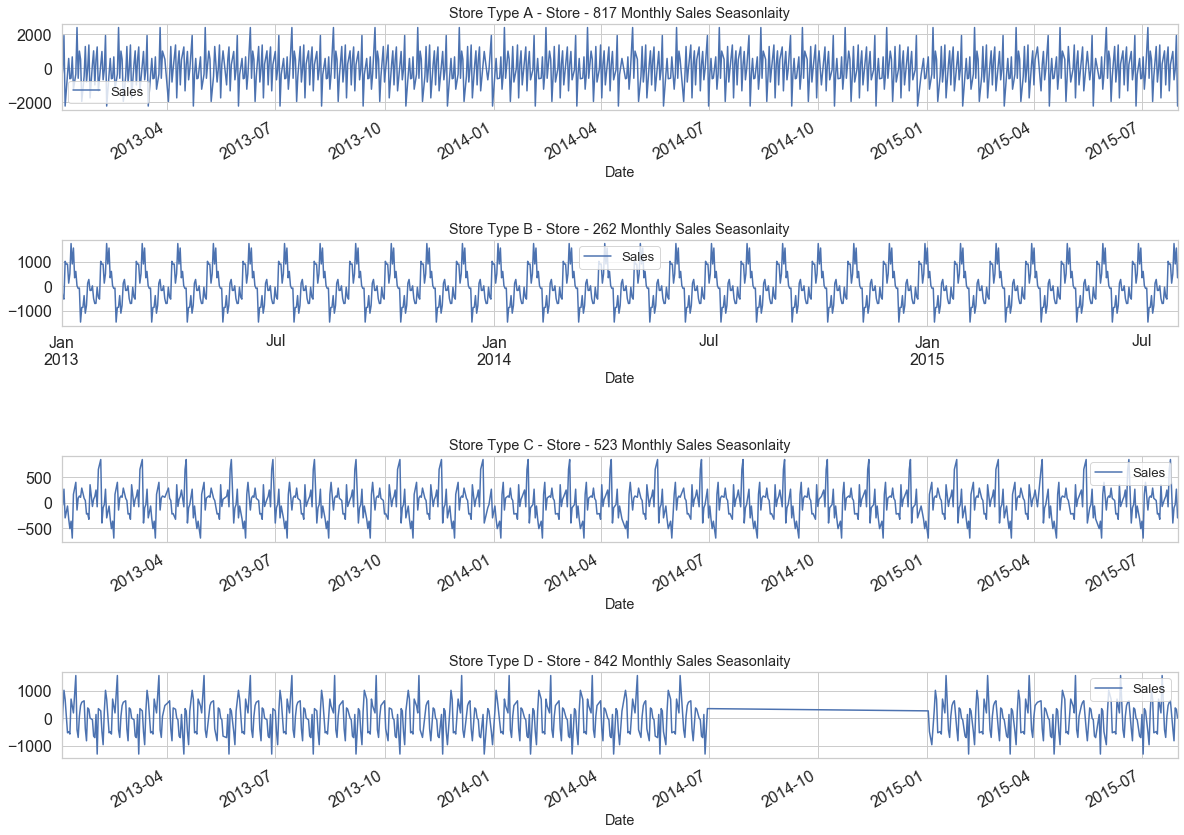

In [33]:
#Will see the analysis for the same four stores above and will look for Monthyly Seasonlaity

f, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (20, 15))
plt.subplots_adjust(hspace = 1.5)
# monthly trend to be shown here
decomp_a = seasonal_decompose(store_typ_a, model = 'additive', freq = 30)
decomp_a.seasonal.plot(ax=ax1,fontsize=16,title= "Store Type A - Store - 817 Monthly Sales Seasonlaity")

decomp_b = seasonal_decompose(store_typ_b, model = 'additive', freq = 30)
decomp_b.seasonal.plot(ax=ax2,fontsize=16, title ="Store Type B - Store - 262 Monthly Sales Seasonlaity")

decomp_c = seasonal_decompose(store_typ_c, model = 'additive', freq = 30)
decomp_c.seasonal.plot(ax=ax3,fontsize=16,title ="Store Type C - Store - 523 Monthly Sales Seasonlaity")

decomp_d = seasonal_decompose(store_typ_d, model = 'additive', freq = 30)
decomp_d.seasonal.plot(ax=ax4,fontsize=16, title = "Store Type D - Store - 842 Monthly Sales Seasonlaity")

plt.show()

**What can be inferred from above:**

1. There is an increasing trend around the time of Christmas for any given store type. As we have taken the only store of each type, it's just a representation
2. Store of Type A has got some similarity with Store Type C
3. Seasonal trends can be observed clearly with an exception to the store belonging to type D. Sales are flat from Aug 2014 to Jan 2015, there could multiple reasons for this like manifestations, refurbishments, road works, etc.

**Let's plot ACF and PACF for the same stores to get an idea as how well these numbers ar correlated**


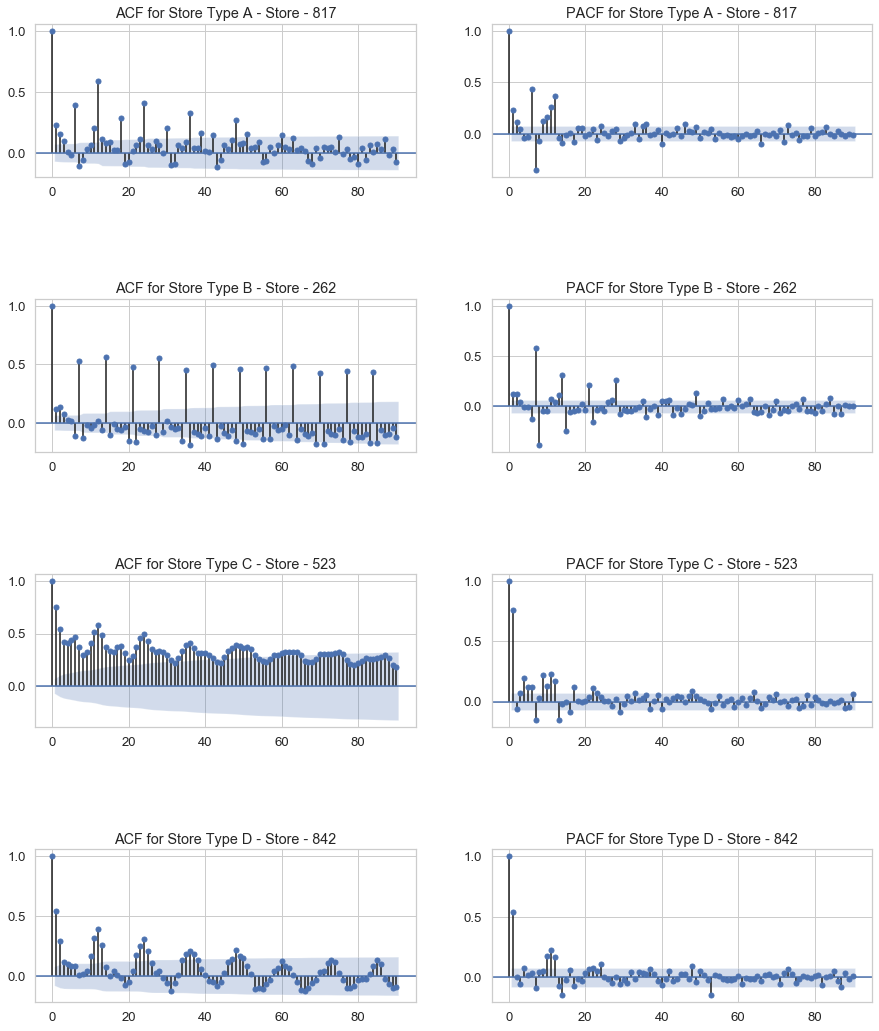

In [34]:
#Maybe we are able to find a pattern here
# "111" means "1x1 grid, first subplot" and "234" means "2x3 grid, 4th subplot".
plt.figure(figsize = (15,18))
plt.subplots_adjust(hspace = 0.8)
# acf and pacf for A
plt.subplot(421); plot_acf(store_typ_a, lags = 90,title="ACF for Store Type A - Store - 817",  ax = plt.gca())
plt.subplot(422); plot_pacf(store_typ_a, lags = 90,title="PACF for Store Type A - Store - 817", ax = plt.gca())

# acf and pacf for B
plt.subplot(423); plot_acf(store_typ_b, lags = 90,title="ACF for Store Type B - Store - 262", ax = plt.gca())
plt.subplot(424); plot_pacf(store_typ_b, lags = 90,title="PACF for Store Type B - Store - 262", ax = plt.gca())

# acf and pacf for C
plt.subplot(425); plot_acf(store_typ_c, lags = 90,title="ACF for Store Type C - Store - 523", ax = plt.gca())
plt.subplot(426); plot_pacf(store_typ_c, lags = 90,title="PACF for Store Type C - Store - 523", ax = plt.gca())

# acf and pacf for D
plt.subplot(427); plot_acf(store_typ_d, lags = 90,title="ACF for Store Type D - Store - 842", ax = plt.gca())
plt.subplot(428); plot_pacf(store_typ_d, lags = 90,title="PACF for Store Type D - Store - 842", ax = plt.gca())

plt.show()

**What can be inferred from above:**
1. Autocorrelation at a certain lag defines how much the series at that lag is correlated with the original series. Any correlation within the blue region is negligible and can be ignored. Here we have considered up to 90 days lagged sales. For the stores above, the sales have a significant correlation with lagged sales up to around 45 days (with high values at 10-14 days lag, 25-30 days lag, and also around 35 and 45 days lagged sales).

2. We can read these plots horizontally. Each horizontal pair is for one 'StoreType', from A to D. In general, those plots are showing the correlation of the series with itself, lagged by x time units correlation of the series with itself, lagged by x time units.

3. Type A and type B: Both types show seasonalities at certain lags. For example type A shows each 8th observation with positives spikes at 16 and 24 lags and so on. For type C we can see all positive spikes but have a continuous increasing and decreasing trend. Seems that they are autocorrelated to each other

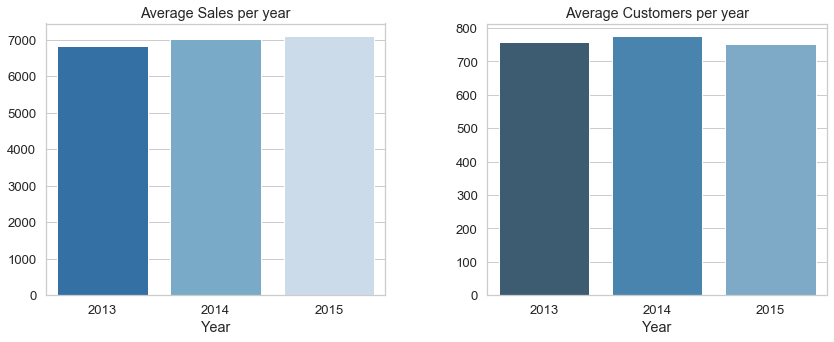

In [35]:
#Let's Plot average sales and average customer footfall
# Plot average sales
fig, (ax1,ax2) = plt.subplots(1,2,sharex=True, figsize=(14,5))
plt.subplots_adjust(wspace = 0.3)

df_sales = df_train1.groupby('Year')['Sales'].mean()
sns.barplot(x=df_sales.index, y=df_sales.values, ax=ax1, palette="Blues_r")
ax1.set_xlabel('Year')
ax1.set_title('Average Sales per year')
# Plot avg customers
df_cust = df_train1.groupby('Year')['Customers'].mean()
sns.barplot(x=df_cust.index, y=df_cust.values, ax=ax2,palette="Blues_d")
ax2.set_xlabel('Year')
ax2.set_title('Average Customers per year')
plt.show()

**What we can infer from DayofWeek plots:**
1. Average Sales are incremental with not much difference, but still increasing trend
2. However, 2014 saw the most customer footfall followed by 2013 and then 2015.
3. 2015 reported the highest average sales with the least customers across three years

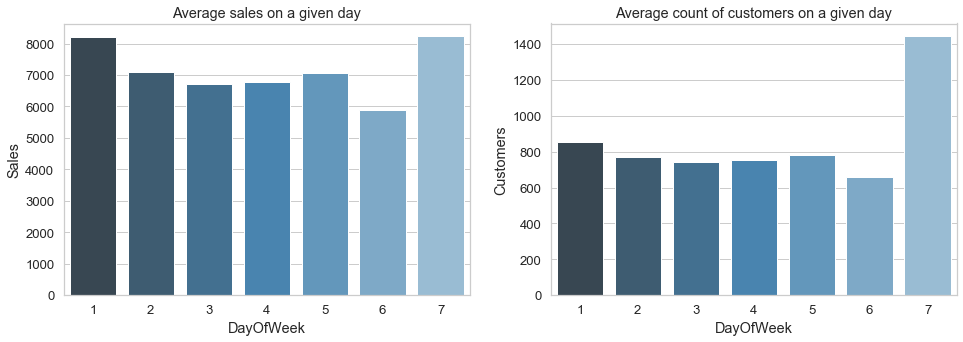

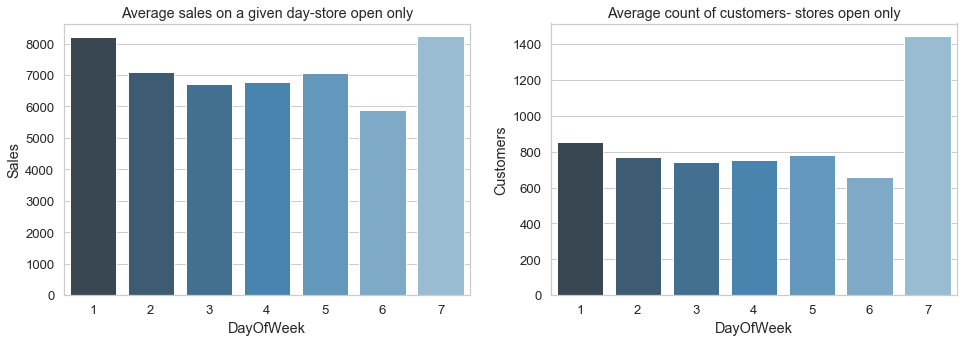

In [36]:
# Plot the results by DayOfWeek for calculating average number of customers and average sales

# This includes both, if the store is open or closed. 
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
df_wdsales = df_train1.groupby('DayOfWeek')['Sales'].mean()
df_wdcust = df_train1.groupby('DayOfWeek')['Customers'].mean()
sns.barplot(x=df_wdsales.index, y=df_wdsales.values, ax=ax1, palette="Blues_d")
ax1.set_title('Average sales on a given day')
ax1.set_ylabel('Sales')
sns.barplot(x=df_wdcust.index, y=df_wdcust.values, ax=ax2, palette="Blues_d")
ax2.set_title('Average count of customers on a given day')
ax2.set_ylabel('Customers')

#Plot a similar bar chart when stores are open only
fig, (ax3,ax4) = plt.subplots(1,2,figsize=(16,5))
df_wdsales = df_train1.groupby('DayOfWeek')['Sales'].mean()
df_wdcust = df_train1.groupby('DayOfWeek')['Customers'].mean()
sns.barplot(x=df_wdsales.index, y=df_wdsales.values, ax=ax3, palette="Blues_d")
ax3.set_title('Average sales on a given day-store open only')
ax3.set_ylabel('Sales')
sns.barplot(x=df_wdcust.index, y=df_wdcust.values, ax=ax4, palette="Blues_d")
ax4.set_title('Average count of customers- stores open only')
ax4.set_ylabel('Customers')
plt.show()

Text(0, 0.5, 'Customers')

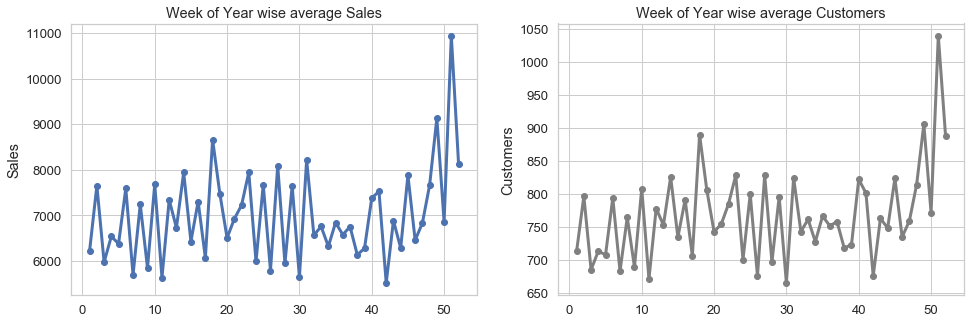

In [37]:
# Week of the year
# In both cases where the store is closed and opened
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
dw_s = df_train1.groupby('WeekOfYear')['Sales'].mean()
dw_c = df_train1.groupby('WeekOfYear')['Customers'].mean()

ax1.plot(dw_s.index.tolist(), dw_s.values, '-', marker = 'o', linewidth = 3)
ax1.set_title('Week of Year wise average Sales')
ax1.set_ylabel('Sales')

ax2.plot(dw_c.index.tolist(), dw_c.values, '-', marker = 'o', linewidth = 3, color = 'grey')
ax2.set_title('Week of Year wise average Customers')
ax2.set_ylabel('Customers')

Text(0, 0.5, 'Sales')

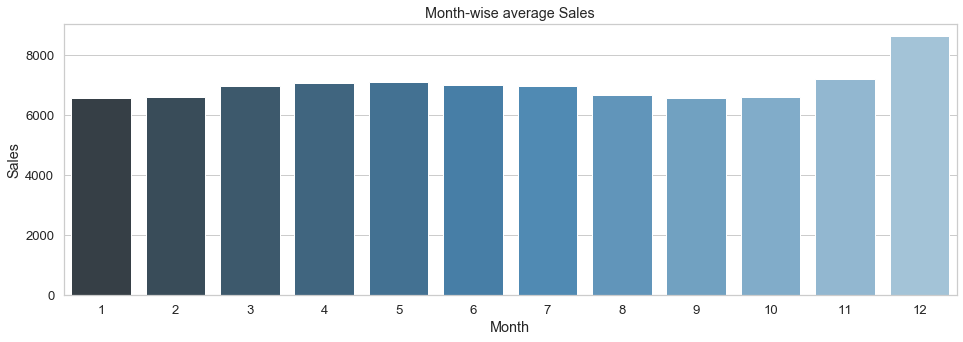

In [38]:
fig, (ax1) = plt.subplots(1,figsize=(16,5))

month_wise = df_train1.groupby('Month')['Sales'].mean()
sns.barplot(x=month_wise.index, y=month_wise.values, ax=ax1, palette="Blues_d")
ax1.set_title('Month-wise average Sales')
ax1.set_ylabel('Sales')

**What we can infer from DayofWeek, Week, and Months plots:**
1. Least average sales are reported if we consider both open and closed days
2. However, if we only consider the open days, it can be seen that most of the sales occur on Monday and Sunday with Sunday having the highest customer footfall

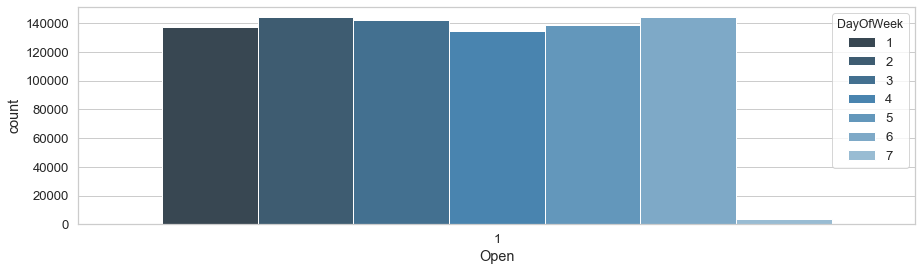

In [39]:
#Count plot showing when a store is open or closed
fig, (ax1) = plt.subplots(1,1,figsize=(15,4))
sns.countplot(x='Open',hue='DayOfWeek', data=df_train1, ax=ax1, palette="Blues_d")

**What we can infer from Open Column plot:**
1. Most of the stores are closed on a Sunday as expected
2. There are still some stores that are closed on a weekday maybe because of a state holiday

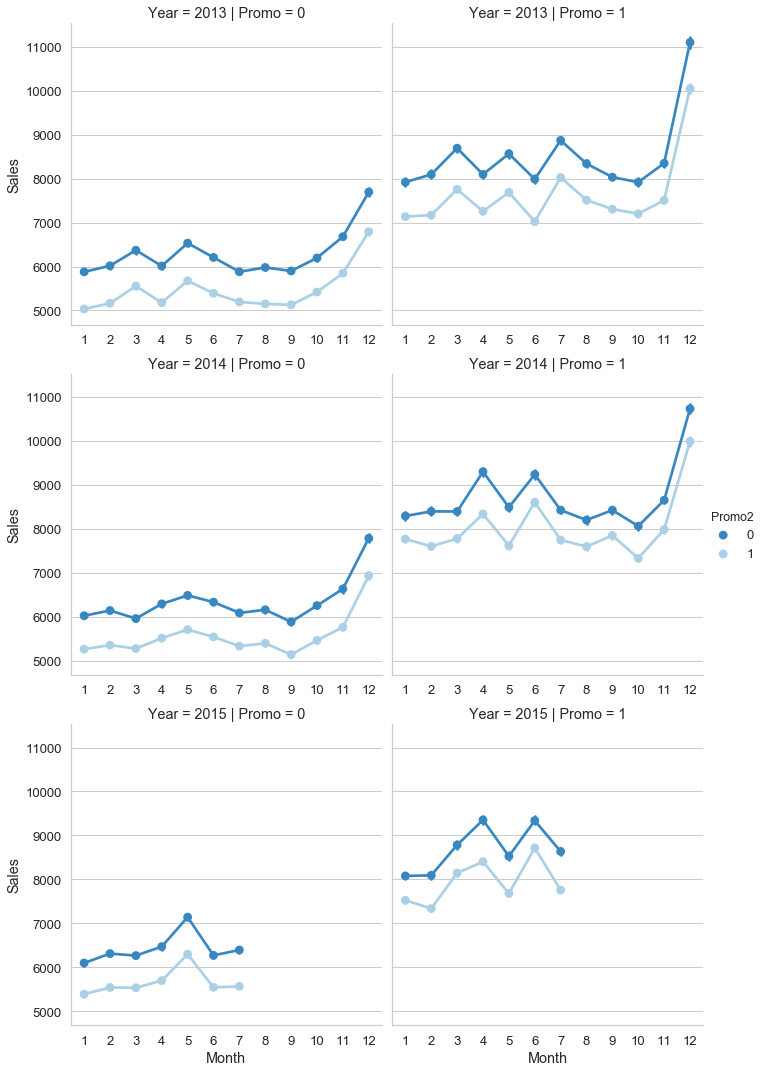

In [40]:
#Promotion- Promo and Promo2
sns.factorplot(data = df_train1, x ="Month", y = "Sales",
               col = 'Promo',
               hue = 'Promo2',
               row = 'Year',
               palette = 'Blues_r',
              sharex=False)

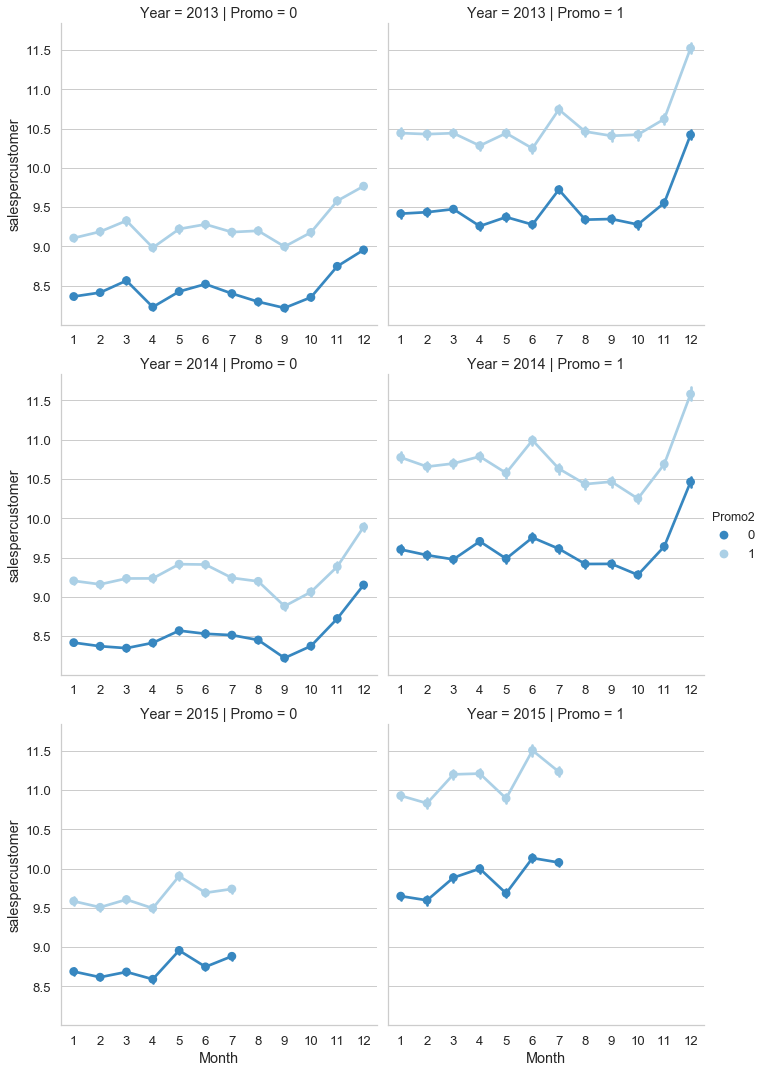

In [41]:
sns.factorplot(data = df_train1, x ="Month", y = "salespercustomer", 
               col = 'Promo', # per store type in cols
               hue = 'Promo2',
               row = 'Year',
               palette = 'Blues_r'
              ,sharex=False)

**What can be inferred from the above plot regarding the Promo effect:**

1. A dramatic change can be seen when comparing Promo=1 to Promo=0. When giving promotions it can be seen that the amount of sales changes considerably.
2. When promo 2 applied post Promo it can be seen that there is no drastic difference in the sales but there is some effect on the sales per customer in that situation. By giving the additional promotions some stores might be inclined to raise their sales especially when the sales are low and also focus on increasing the sales per customer during off-peak seasons

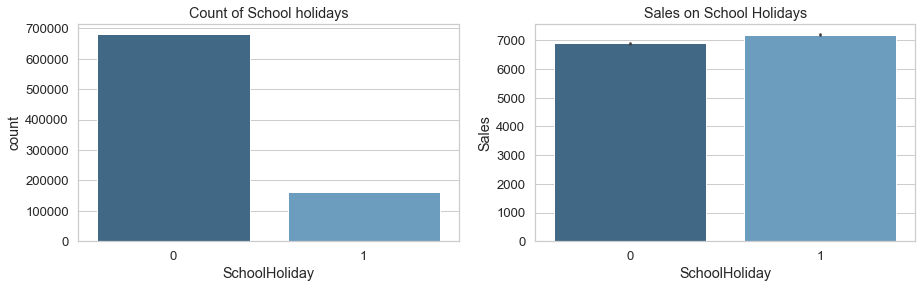

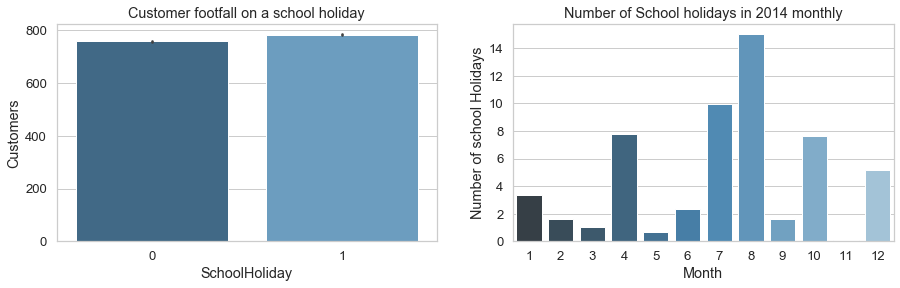

In [42]:
#School Holiday.
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,4))
fig, (ax3,ax4) = plt.subplots(1,2,figsize=(15,4))

sns.countplot(x='SchoolHoliday', data=df_train1, ax=ax1, palette="Blues_d")
ax1.set_title('Count of School holidays')

sns.barplot(x='SchoolHoliday', y='Sales', data=df_train1, ax=ax2, palette="Blues_d")
ax2.set_title('Sales on School Holidays')

sns.barplot(x='SchoolHoliday', y='Customers', data=df_train1, ax=ax3,palette="Blues_d")
ax3.set_title('Customer footfall on a school holiday')

sch_hol_df_2014 = (df_train1[(df_train1['SchoolHoliday']==1)&(df_train1['Year']==2014)].groupby('Month')['SchoolHoliday']
                     .value_counts()
                     .div(1115)
                     .rename('Number of school Holidays')
                     .reset_index()
                     .sort_values('Month'))
sns.barplot(x="Month", y="Number of school Holidays", data=sch_hol_df_2014, ax = ax4,palette="Blues_d")
ax4.set_title('Number of School holidays in 2014 monthly')
plt.show()


**What we can infer from SchoolHolidays plots:**

1.We can observe that most of the stores remain closed during State and School Holidays. But it is interesting to note that the number of stores opened during School Holidays was more than that were opened during State Holidays.

2.Another important thing to note is that the stores which were opened during School holidays had more sales than normal.

3.**The last two plot shows how the school holidays are distributed over the months in 2014. Months of July and August are summer holidays whereas winter break starts in December with equivalent holidays in April. Visualizing holidays is important for the prediction as the test data lies in August and September. Hence we can see that sales might trigger upwards during August and can maintain momentum until September.**

Text(0, 0.5, 'Sales')

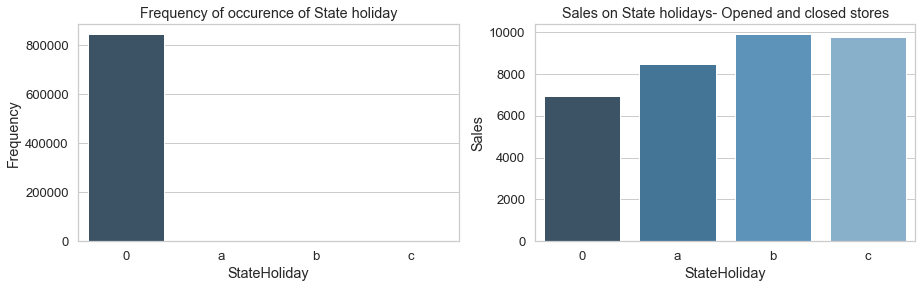

In [43]:
# StateHoliday
fig, (ax5,ax6) = plt.subplots(1,2,figsize=(15,4))

df_train1["StateHoliday"].loc[df_train1["StateHoliday"] == 0] = "0"
stateh_df = df_train1.groupby('StateHoliday')['Date'].count()
sns.barplot(stateh_df.index, stateh_df.values, ax = ax5,palette="Blues_d")
ax5.set_ylabel('Frequency')
ax5.set_title('Frequency of occurence of State holiday')


stateh_sales = df_train1.groupby('StateHoliday')['Sales'].mean()
sns.barplot(x=stateh_sales.index, y=stateh_sales.values, ax=ax6,palette="Blues_d")
ax6.set_title('Sales on State holidays- Opened and closed stores')
ax6.set_ylabel('Sales')


**What we can infer from StateHolidays plots:**

1.The number of state holidays of type 'a' are most frequent while type 'c' are least frequent.

2.Average sales on state holidays are significantly less than other days. Further, it is lowest on a 'c' type state holiday as per the second graph.

In [44]:
#StoreType
display(df_train1.groupby('StoreType')['Sales'].describe())
display(df_train1.groupby('StoreType')['Customers', 'Sales'].sum())


,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


**What we can infer from StoreType analysis above:**

1. Stores of type B has the highest average of Sales among others considering the datais comparitvely lesser for StoreType B.
2. Type A stores has higher count of total Customers and Sales. StoreType D goes on the second place in both Sales and Customers.


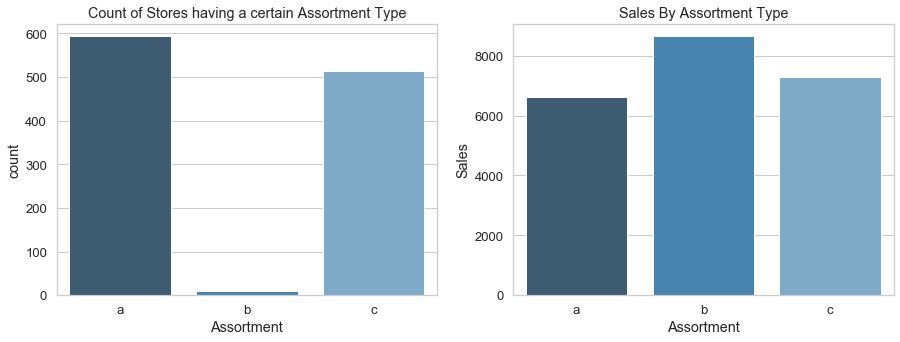

In [45]:
#Assortment
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
sns.countplot(x='Assortment', data=df_store, order=['a','b','c'], ax=ax1,palette="Blues_d")
ax1.set_title('Count of Stores having a certain Assortment Type')

assort_sales = df_train1.groupby('Assortment')['Sales'].mean()
sns.barplot(x=assort_sales.index, y=assort_sales.values, ax=ax2,palette="Blues_d")
ax2.set_title('Sales By Assortment Type')
ax2.set_ylabel('Sales')
plt.show()

**What we can infer from Assortment Plots above:**

1. Stores selling assortment type 'a' are have got the highest count followed by type C while stores selling assortment type 'b' are least common. This indicates that customers are maorly shopping for basic ammenities
2. However, sales are the highest for assortment type b.


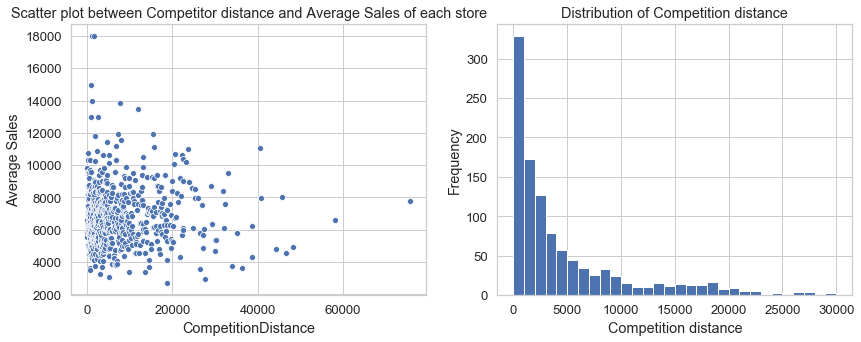

In [46]:
# CompetitionDistance
comp_df = df_train1[(df_train1['Sales']>0)&(~df_train1['CompetitionDistance'].isna())&\
                    (df_train1.CompetitionOpenInMonths>0)].groupby('CompetitionDistance')['Sales'].mean()
# Plot CompetitionDistance Vs Sales
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,5))
sns.scatterplot(x=comp_df.index,y=comp_df.values, ax = ax1)
ax1.set_ylabel('Average Sales')
ax1.set_title('Scatter plot between Competitor distance and Average Sales of each store')
#HIstogram
ax2.hist(x = df_store['CompetitionDistance'].dropna(), bins = 30, range=(0,30000))
ax2.set_ylabel('Frequency')
ax2.set_xlabel('Competition distance')
ax2.set_title('Distribution of Competition distance')
plt.show()

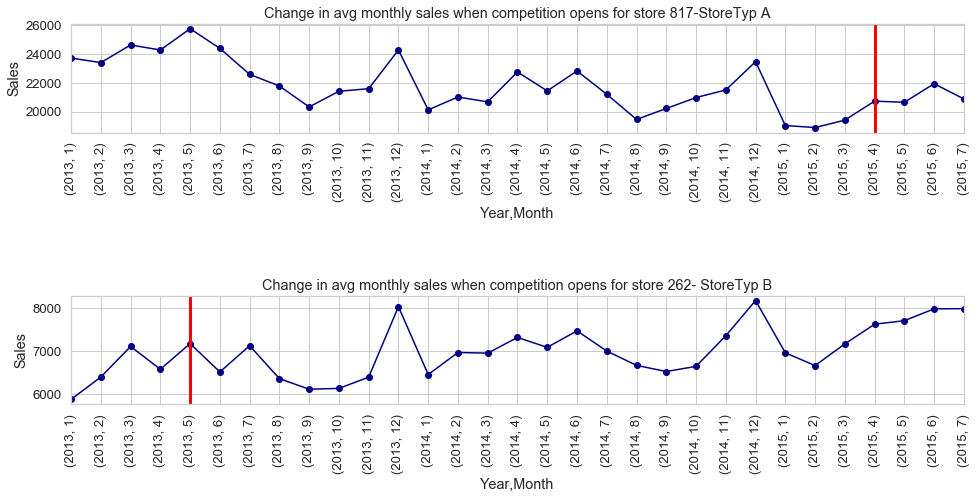

In [47]:
#Let's now see for a couple of stores what happened to their sales when a competitor opens a store within the range defined above
f = plt.figure(figsize=(16,22))
plt.subplots_adjust(hspace = 1.5)

store_data = df_train1[df_train1['Store'] ==817]
average_store_sales = store_data.groupby(['Year','Month'])['Sales'].mean()
ax1 = f.add_subplot(511)
ax1 = average_store_sales.plot(marker='o', color='navy')
ax1.set_xticks(range(len(average_store_sales)))
ax1.set_xticklabels(average_store_sales.index.tolist(), rotation=90)

# The sales data is from 2013 to 2015and hence we need to make sure that year>2013 and there are no nan values for the given store since the competition started
# So, we need to check if year>=2013 and y & m aren't NaN values.
year_compt = df_train1["CompetitionOpenSinceYear"].loc[df_train1["Store"]  == 5].values[0]
month_compt = df_train1["CompetitionOpenSinceMonth"].loc[df_train1["Store"] == 5].values[0]

if year_compt>=2013 and year_compt == year_compt and month_compt == month_compt:
    ax1.axvline(x=((year_compt-2013) * 12) + (month_compt - 1), linewidth=3, color='red')

ax1.set_title('Change in avg monthly sales when competition opens for store 817-StoreTyp A')
ax1.set_ylabel('Sales')

#********************************************************************************

#Lets take another example to who the effect. For example store 262
store_data_262 = df_train1[df_train1['Store'] == 740]
average_store_sales_262 = store_data_262.groupby(['Year','Month'])['Sales'].mean()
ax2 = f.add_subplot(512)
ax2 = average_store_sales_262.plot(marker='o',color='navy')
ax2.set_xticks(range(len(average_store_sales_262)))
ax2.set_xticklabels(average_store_sales_262.index.tolist(), rotation=90)

# The sales data is from 2013 to 2015and hence we need to make sure that year>2013 and there are no nan values for the given store since the competition started
# So, we need to check if year>=2013 and y & m aren't NaN values.
year_compt_262 = df_train1["CompetitionOpenSinceYear"].loc[df_train1["Store"]  == 262].values[0]
month_compt_262 = df_train1["CompetitionOpenSinceMonth"].loc[df_train1["Store"] == 262].values[0]

if year_compt_262>=2013 and year_compt_262 == year_compt_262 and month_compt_262 == month_compt_262:
    ax2.axvline(x=((year_compt_262-2013) * 12) + (month_compt_262 - 1), linewidth=3, color='red')

ax2.set_title('Change in avg monthly sales when competition opens for store 262- StoreTyp B')
ax2.set_ylabel('Sales')

plt.show()

**What we can infer from the Competition field above:**

1. The Scatter plot does not show any direct relationship b/w sales and competitor distance.
2. Histogram still shows that most of the competitors are in the range of 5KMs with only a few outliers ranging from 20-30Kms
3. From the above chart it can be seen that since the time the competition was in place, how much impact it has added to the store. For example, for store 5 the impact on avg sales is not that huge, a little downturn can be seen in the following month, whereas for store 740, the sales increased in the very next month once the competition arrived and then decreased. So a possible pattern cannot be established
4. It will still hold true that for other stores (as we cant analyze all of them here), there might be a pattern of increasing or decreasing sales but that is not guaranteed

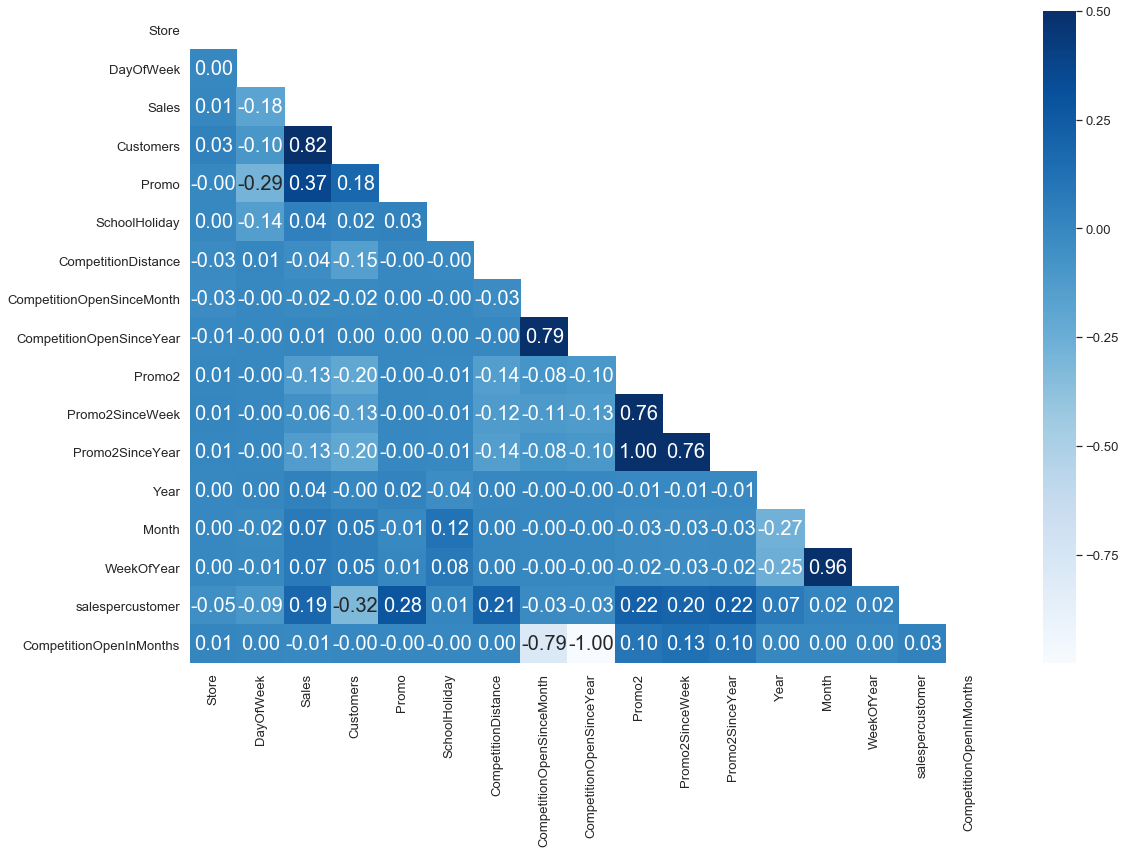

In [48]:
#Correlation Analysis
# exclude 'Open' variable
corr_mat = df_train1.drop('Open', axis = 1).corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_mat, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
fig,ax1 = plt.subplots(figsize=(18,12))
sns.heatmap(corr_mat, mask = mask,annot_kws={"fontsize":20},
            annot=True, vmax=.5,fmt='.2f',
            ax = ax1, cmap = "Blues")
bottom, top = ax1.get_ylim()
ax1.set_ylim(bottom +0.5, top -0.5) 
plt.show()

**What can be inferred from Correlation Plot above:**

1. High positive correlation b/w customers and sales = 0.82 that tells us clearly that higher customer = higher sales and that is what we have seen before as well.
2. If not huge but still a 0.37 positive correlation can be seen b/w running a promo and store sales. That does imply that sales get to take off when there is a promo running. The same also holds true for sales per customer while running a promo = 0.28 which tells us that sales per customer increases while a promo is running
3. Sales per customer positively correlates with Competition Distance = 0.21 that indicates if the competitor store distance is huge then a customer would buy from our store rather than going there
4. A positive correlation exists b/w customers and running a promo = 0.18 which indicates that when a store runs a promo it can expect a higher footfall.
    

# 1.5 EDA Takeaways and Observations
1. Median sale is 6369 considering only stores that were open. There are some outliers in the sales data with some having sales more than 40000.
2. The dependent variable, sales are not normally distributed. Upon taking the log transform, we find that it is much closer to a normal distribution. We will see later if this will help us in modeling or not.
3. It can be seen that there is evidence of peaks followed by troughs in monthly average sales. Almost for every steep rise in sales, there is an immediate fall. A sharp rise in sales can be seen during the end of the year, around Christmas time and smaller spikes can be seen during the summer months (June-September). A steep decline can be seen in the month of January every year because of the end of the festive season.
4. As per the ACF Plot, it can be seen that the sales have a significant correlation with lagged sales up to around 45 days (with high values at 10-14 days lag and 25-30 days lag).
5. Average sales have increased as we progress over the years while an average number of customers visiting has increased from 2013 to 2014. Since we have only around 7 months of data for 2015 it's difficult to comment about 2015.
6. Most of the stores remain closed on Sundays. So if we consider both opened and closed stores average Sunday sales are lowest. But on the contrary, if we consider Open stores only, Sunday and Monday (day 1) sales are among the highest. The number of customers visiting on Sundays is much more than any other day on average.
7. Sales are generally higher when there is promotions are given in a store. A dramatic change can be seen when comparing Promo=1 to Promo=0. When giving promotions it can be seen that the amount of sales changes considerably. When promo 2 applied post Promo it can be seen that there is no drastic difference in the sales but there is some effect on the sales per customer in that situation. By giving the additional promotions some stores might be inclined to raise their sales especially when the sales are low and also focus on increasing the sales per customer during off-peak seasons.
8. The number of state holidays of type 'a' is most frequent while type 'c' is the least frequent. For every state holiday, the average sales are higher than in other days. 
9. July and August have maximum school holidays. This is important because our test data lies in August and September that will impact sales because of this. There is also a winter break which is reflected by a number of holidays in December. Apart from that, there are some school holidays in March and October.
10. Stores of type 'a' are most frequently occurring while store type 'b' are least common. Median sales at storetyp b are a little on the higher side with a comparative lesser customer footfall.
11. Stores that do not participate in promo2 have higher sales than the ones that have promo2. So, they might be trying to attract more customers by giving additional promotions to increase sales.
12. For periods when there is a promo 2 and when there aren’t the sales are almost similar. So by giving the additional promotions these stores might be trying to increase the sale especially when they expect a dip in sales. Most stores follow the Jan, Apr, July, Oct cycle (i.e. Promo2 with a gap of 2 months).
13. There is a very low negative correlation almost negligible that suggests that there are some relationship b/w sales and how far the competitor store is located. Most of the stores are located within a range of 5KM only whereas some outliers are located around 30KM. As the field is not normally distributed, we can take a log of this field similar to sales and see if that impacts predictions later on. But looking at sales per customer, competitor distance does play a role, we can assume here if the competitor is closely located it may impact the sale of store X as the sales per customer will go down.
14. For some type of stores when a competitor opens a store in the neighborhood of Store X, the monthly sales of the store generally show a downward trend.

**END OF PART1 OF THE TASK**! **Please refer to Part 2 for Feature Engineering and Models**